In [1]:
import math
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm 
import matplotlib.cm as cm
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from collections import deque
import scipy
import copy
import time

D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
#global veriable 
Uniform_low_bound=0
Uniform_up_bound=1
Agent_number_n=3

number_of_groups=2

Normal_loc=0.5
Normal_scale=0.2
Normal_loc1=0.3
Normal_loc2=0.7
Normal_scale1=0.1
Normal_scale2=0.1
Distribution_number=20000
#target = "min_sum"
target = "min_max"

In [3]:
popSize = 400
eliteSize = 200
mutationRate = 1
generations = 50
test_fitness_number = 100


global NeighborhoodRate
NeighborhoodRate = 0.2

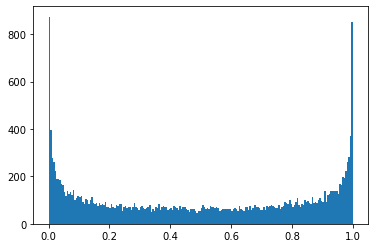

10000
10000


In [4]:

seed = 7
np.random.seed(seed)
#exec(open('distribution/uniform.py').read())
exec(open('../../../distribution/beta.py').read())
#exec(open('../../../distribution/uniform.py').read())
#exec(open('../../../distribution/twopeak.py').read())
for i in range(len(value_list)):
    for j in range(len(value_list[0])):
        if(value_list[i][j]<=0):
            value_list[i][j]=0
        if(value_list[i][j]>=1):
            value_list[i][j]=1
            
value_list1=np.array(value_list)
for i in range(min(Agent_number_n,1)):
    pa=value_list1[:,i]
    plt.hist(pa,bins=200)
    plt.show()


X_train,  X_test = train_test_split(value_list, test_size=0.5, random_state=seed)


dataset_size = len(X_train)
print(dataset_size)
#print(X_train[:100])
print(len(X_test))
#run_cs()


In [5]:
#Cost Sharing
def run_cs_prue():
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test=X_test[i];
        
        for k in range(Agent_number_n,0,-1):
            count=0;
            delay=0;
            for item in test:
                if(item+1e-9>=1.0/k):
                    count+=1;
                else:
                    delay+=1;
            if(count>=k):
                temp_delay=delay;
                if temp_delay != 0 :
                    temp_max_delay = 1
                break;
            if(k<=1):
                #print(test);
                temp_delay=Agent_number_n;
                temp_max_delay=1
        sum_delay+=temp_delay
        max_delay+=temp_max_delay
                
    print("max_delay",max_delay/test_number);
    print("sum_delay",sum_delay/test_number);
    
run_cs_prue()

max_delay 0.7822
sum_delay 1.7566


In [6]:
#Cost Sharing
def run_cs_prue():
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test=X_test[i];
        
        for k in range(Agent_number_n,0,-1):
            count=0;
            delay=0;
            for item in test:
                if(item+1e-9>=1.0/k):
                    count+=1;
                else:
                    delay+=1;
            if(count>=k):
                temp_delay=delay;
                if temp_delay != 0 :
                    temp_max_delay = 1
                break;
            if(k<=1):
                #print(test);
                temp_delay=Agent_number_n;
                temp_max_delay=1
        sum_delay+=temp_delay
        max_delay+=temp_max_delay
                
    print("max_delay",max_delay/test_number);
    print("sum_delay",sum_delay/test_number);
    
run_cs_prue()

max_delay 0.7822
sum_delay 1.7566


In [7]:

class head_list:
    def __init__(self, bid,t_allocation):
        self.bid_list = []
        self.t_allocation_list = []
        self.bid_list.append(bid)
        self.t_allocation_list.append(t_allocation)
        self.delay = 0
        self.fitness = 0.0
    
    def Fitness(self):
        
        if(self.delay == 0 or self.fitness==0 ):
            if (non_dominant(self)==False):
                self=produce_initial_head_list()
            self.delay = run_training_test(self)
            self.fitness = self.delay
        else:
            if(random.random()<NeighborhoodRate):
                if (non_dominant(self)==False):
                    self=produce_initial_head_list()
                self.delay = run_training_test(self)
                self.fitness = self.delay
                
                
            
        return self

    def Fitness_all(self):
        self.delay = run_all_training_test(self)
        self.fitness = self.delay
        return self

    def new(self):
        self.bid_list = []
        self.t_allocation_list = []
        self.delay = 0
        self.fitness = 0.0
    
    def debug(self):
        for i in range(len(self.bid_list)):
            print("bid: ",self.bid_list[i])
            print("t: ",self.t_allocation_list[i])

            
        print(self.fitness)
        print()


In [8]:
def run_loop(test,head):
    
    for i in range(len(head.t_allocation_list)):
        if(sum(test*head.t_allocation_list[i]+1e-6 >= head.bid_list[i]) == Agent_number_n):
            return Agent_number_n - sum(head.t_allocation_list[i]), np.ones(Agent_number_n) - head.t_allocation_list[i]
        
    return Agent_number_n, np.ones(Agent_number_n)
    
def run_loop_value(test,head):
    
    for i in range(len(head.t_allocation_list)):
        if(sum(test*head.t_allocation_list[i]+1e-6 >= head.bid_list[i]) == Agent_number_n):
            return head.bid_list[i], head.t_allocation_list[i],i
        
    return np.zeros(Agent_number_n), np.zeros(Agent_number_n),-1
    
def run_training_test(head):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(test_fitness_number):
        test_number+=1
        test = copy.deepcopy(X_train[random.randint(0,len(X_train)-1)])
        temp_sum_delay, temp_max_delay_list = run_loop(test,head)
        max_delay+=max(temp_max_delay_list)
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
    if(target == "min_sum"):
        return sum_delay/test_number
    if(target == "min_max"):
        return max_delay/test_number
    
    
def run_all_training_test(head):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_train)):
        test_number+=1
        test = copy.deepcopy(X_train[i])
        temp_sum_delay, temp_max_delay_list = run_loop(test,head)
        max_delay+=max(temp_max_delay_list)
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
    if(target == "min_sum"):
        return sum_delay/test_number
    if(target == "min_max"):
        return max_delay/test_number

def run_all_test(head):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_test)):
        test_number+=1
        test = copy.deepcopy(X_test[i])
        
        temp_sum_delay, temp_max_delay_list = run_loop(test,head)

        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
    if(target == "min_sum"):
        return sum_delay/test_number
    if(target == "min_max"):
        return max_delay/test_number


1.Create a fitness function

In [9]:
def appen(x, y, index):
    x.bid_list.append(y.bid_list[index])
    x.t_allocation_list.append(y.t_allocation_list[index])


X = copy.deepcopy(X_train)


# def non_dominant(head):

#     for i in range(len(head.bid_list)):
#         si_bid = head.bid_list[i]
#         si_t = head.t_allocation_list[i]
#         for j in range(i + 1, len(head.bid_list)):
#             sj_bid = head.bid_list[j]
#             sj_t = head.t_allocation_list[j]
#             sum_abs = 0
#             for k in range(Agent_number_n):
#                 sum_abs += math.fabs(si_t[k] - sj_t[k])
#             if (sum_abs < 1e-4):
#                 return False

#             if (sum((sj_t <= 1e-4)) == Agent_number_n):
#                 return False
            
#             for k in range(Agent_number_n):
#                 if sj_t[k]!=0 and si_t[k]!=0:
#                     if(sj_bid[k]<si_bid[k] or sj_t[k]>si_t[k]):
#                         return False

#     return True

def non_dominant_all_training(head):

    for i in range(len(head.bid_list)):
        si_bid = head.bid_list[i]
        si_t = head.t_allocation_list[i]
        for j in range(i + 1, len(head.bid_list)):
            sj_bid = head.bid_list[j]
            sj_t = head.t_allocation_list[j]
            sum_abs = 0
            for k in range(Agent_number_n):
                sum_abs += math.fabs(si_t[k] - sj_t[k])
            if (sum_abs < 1e-4):
                return False

            if (sum((sj_t <= 1e-4)) == Agent_number_n):
                return False
            
#             for k in range(Agent_number_n):
#                 if sj_t[k]!=0 and si_t[k]!=0:
#                     if(sj_bid[k]<si_bid[k] or sj_t[k]>si_t[k]):
#                         return False

    for i in range(Agent_number_n):
        hash_v = [1 for i in range(len(head.bid_list))]
        for j in range(len(X)):
            test_domi = X[j]
            test_domi_i = copy.deepcopy(test_domi)
            random_index = random.randint(0, Agent_number_n-1)
            bid, t, ix = run_loop_value(test_domi, head)
            if(ix!=-1):
                hash_v[ix] = 0
            vi = test_domi[random_index] * t[random_index] - bid[random_index]
            test_domi_i[random_index] = random.random()
            bid_i, t_i, x_i = run_loop_value(test_domi_i, head)

            v_i = test_domi[random_index] * \
                t_i[random_index] - bid_i[random_index]
            if(v_i > vi):
                return False
#         if(sum(hash_v) != 0):
#             if(sum(hash_v)*random.random()>0):
#                 return False
            
    return True

def non_dominant(head):

    for i in range(len(head.bid_list)):
        si_bid = head.bid_list[i]
        si_t = head.t_allocation_list[i]
        for j in range(i + 1, len(head.bid_list)):
            sj_bid = head.bid_list[j]
            sj_t = head.t_allocation_list[j]
            sum_abs = 0
            for k in range(Agent_number_n):
                sum_abs += math.fabs(si_t[k] - sj_t[k])
            if (sum_abs < 1e-4):
                return False
            
            if (sum((sj_t <= 1e-4)) == Agent_number_n):
                return False

    for i in range(Agent_number_n):
        hash_v = [1 for i in range(len(head.bid_list))]
        for j in range(test_fitness_number):
            test_domi = X[random.randint(0, len(X)-1)]
            test_domi_i = copy.deepcopy(test_domi)
            random_index = random.randint(0, Agent_number_n-1)
            bid, t, ix = run_loop_value(test_domi, head)
            if(ix!=-1):
                hash_v[ix] = 0
            vi = test_domi[random_index] * t[random_index] - bid[random_index]
            test_domi_i[random_index] = random.random()
            bid_i, t_i, x_i = run_loop_value(test_domi_i, head)

            v_i = test_domi[random_index] * \
                t_i[random_index] - bid_i[random_index]
            if(v_i > vi):
                return False
        if(sum(hash_v) != 0):
            #if(sum(hash_v)*random.random()>Agent_number_n):
            if(sum(hash_v)*random.random()>0):
                return False

    return True



In [10]:
# x = head_list(np.array([1, 0, 0]), np.array([1, 1, 1]))
# y1 = head_list(np.array([0 , 1 / 2, 1 / 2]), np.array([0.45, 1, 1]))
# x.Fitness()
# x.debug()
# appen(x, y1, 0)


# print(non_dominant(x))
# x.fitness = 0
# x.Fitness()
# x.debug()

## Create our initial population

Initial generator

Create first "population" (list of routes)

In [11]:
pool_items=[]
#for i in range(1,Agent_number_n+1):
#    pool_items.append(1.0/i)
pool_items.append(0.0) 
pool_items.append(1.0) 
for i in range(1,Agent_number_n+1):
    pool_items.append(1.0/float(i)) 

    
for i in range(1,101):
    #pool_items.append(np.random.random())
    pool_items.append(float(i)/100) 
#print(pool_items)
def produce_initial_head_list():
    initial_bid_list=[]
    initial_t_list=[]
    
    if(random.random()>0.5):
        for j in range(Agent_number_n):
            initial_bid_list.append(pool_items[np.random.randint(0,len(pool_items)-1)])
        
        ran_1 = np.array([random.randint(0,1) for i in range(Agent_number_n)])
        initial_bid_list = np.array(initial_bid_list) - ran_1*1000
        
        ran_2 = np.array([random.randint(0,2) for i in range(Agent_number_n)])
        for j in range(Agent_number_n):
            initial_t_list.append(pool_items[np.random.randint(0,len(pool_items)-1)])
        initial_t_list_temp = initial_t_list * (ran_2==1)
        initial_t_list_temp += (ran_2==2)
        
    else:
        ran_1 = np.array([random.randint(0,1) for i in range(Agent_number_n)])
        initial_bid_list = np.array(ran_1*1000)
        initial_t_list_temp = ran_1
#         if(random.random()>0.5):
#             initial_t_list_temp = ran_1
#         else:
#             ran_2 = np.array([random.randint(0,2) for i in range(Agent_number_n)])
#             for j in range(Agent_number_n):
#                 initial_t_list.append(pool_items[np.random.randint(0,len(pool_items)-1)])
#             initial_t_list_temp = initial_t_list * (ran_2==1)
#             initial_t_list_temp += (ran_2==2)
        
    
    return head_list(scipy.special.softmax(initial_bid_list),np.array(initial_t_list_temp))

global population,bid,t
population = []
def init_dfs(deep):
    global population,bid,t
    if deep == Agent_number_n:
        population.append(head_list(scipy.special.softmax(bid),np.array(t)))
        return
    
    bid[deep]=0;
    t[deep]=0;
    init_dfs(deep+1)
    bid[deep]=1000;
    t[deep]=1;
    init_dfs(deep+1)
    return

def initialPopulation():
    global population,bid,t
    population = []
    bid=np.ones(Agent_number_n)
    t= np.ones(Agent_number_n)
    init_dfs(0)
    for i in range(popSize):
        population.append(produce_initial_head_list())
    return population



In [12]:

pop = np.array(initialPopulation())

for i in range(len(pop)):
     print(pop[i].bid_list)
        
for i in range(len(pop)):
     print(pop[i].t_allocation_list)

[array([0.33333333, 0.33333333, 0.33333333])]
[array([0., 0., 1.])]
[array([0., 1., 0.])]
[array([0. , 0.5, 0.5])]
[array([1., 0., 0.])]
[array([0.5, 0. , 0.5])]
[array([0.5, 0.5, 0. ])]
[array([0.33333333, 0.33333333, 0.33333333])]
[array([0., 0., 1.])]
[array([1., 0., 0.])]
[array([0., 1., 0.])]
[array([0., 1., 0.])]
[array([0.33333333, 0.33333333, 0.33333333])]
[array([0., 0., 1.])]
[array([0., 1., 0.])]
[array([0. , 0.5, 0.5])]
[array([0.59145898, 0.40854102, 0.        ])]
[array([0., 1., 0.])]
[array([1., 0., 0.])]
[array([0.33333333, 0.33333333, 0.33333333])]
[array([1., 0., 0.])]
[array([0.5, 0.5, 0. ])]
[array([0., 1., 0.])]
[array([0. , 0.5, 0.5])]
[array([0.35912605, 0.30602704, 0.33484691])]
[array([0., 1., 0.])]
[array([0., 0., 1.])]
[array([0., 0., 1.])]
[array([1., 0., 0.])]
[array([0., 1., 0.])]
[array([0., 1., 0.])]
[array([0.35655915, 0.28329822, 0.36014263])]
[array([1., 0., 0.])]
[array([1., 0., 0.])]
[array([0.42311474, 0.        , 0.57688526])]
[array([0., 1., 0.])

## Create the genetic algorithm

Rank individuals

In [13]:
def rank_heads(population):
    fitnessResults = []
    for i in range(0,len(population)):
        temp = population[i].Fitness()
        fitnessResults.append([i, temp.delay, temp])
    fitnessResults = np.array(fitnessResults)
    
    return sorted(fitnessResults, key = operator.itemgetter(1))

def rank_heads_all(population):
    fitnessResults = []
    for i in range(0,len(population)):
        temp = population[i].Fitness_all()
        fitnessResults.append([i, temp.delay, temp])
    fitnessResults = np.array(fitnessResults)
    
    return sorted(fitnessResults, key = operator.itemgetter(1))

Create a selection function that will be used to make the list of parent routes

In [14]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness","Tree"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(int(len(popRanked))):
        selectionResults.append(popRanked[i][0])
    return selectionResults

Create mating pool

In [15]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

Create a crossover function for two parents to create one child

In [16]:
def breed(parent1, parent2):
    child = copy.deepcopy(parent1)
    
    geneA_1 = int(random.random() * len(parent1.bid_list))
    geneB_1 = int(random.random() * len(parent1.bid_list))
    startGene_1 = min(geneA_1, geneB_1)
    endGene_1 = max(geneA_1, geneB_1)
    
    geneA_2 = int(random.random() * len(parent2.bid_list))
    geneB_2 = int(random.random() * len(parent2.bid_list))
    startGene_2 = min(geneA_2, geneB_2)
    endGene_2 = max(geneA_2, geneB_2)
    
    child.bid_list = []
    child.t_allocation_list = []

    for i in range(startGene_1):
        child.bid_list.append(parent1.bid_list[i])
        child.t_allocation_list.append(parent1.t_allocation_list[i])
        
    for i in range(startGene_2,endGene_2+1):
        child.bid_list.append(parent2.bid_list[i])
        child.t_allocation_list.append(parent2.t_allocation_list[i])
        
    for i in range(endGene_1, len(parent1.bid_list)):
        child.bid_list.append(parent1.bid_list[i])
        child.t_allocation_list.append(parent1.t_allocation_list[i])
        
    if   non_dominant(child):
        child.fitness = 0;
        return child
    else:
        return False 
    

Create function to run crossover over full mating pool

In [17]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(eliteSize):
        children.append(matingpool[i])

    for i in range(popSize):
        if (random.random() < mutationRate):
            swapped = copy.deepcopy(pool[random.randint(0,len(matingpool)-1)])
            swapWith = copy.deepcopy(pool[random.randint(0,len(matingpool)-1)])
            
            for j in range(len(swapWith.bid_list)):
                swapped.bid_list.append(swapWith.bid_list[j])
                swapped.t_allocation_list.append(swapWith.t_allocation_list[j])
            
            if (non_dominant(swapped)):
#                 print("##########")
#                 swapped.debug()
#                 print("##########")
                swapped.fitness = 0
                children.append(swapped)

    for i in range(popSize):
        if (random.random() < mutationRate):
            child = breed(pool[random.randint(0,len(matingpool)-1)], pool[random.randint(0,len(matingpool)-1)])
            if (child != False):
#                 print("##########")
#                 child.debug()
#                 print("##########")
                child.fitness = 0
                children.append(child)
    
#     print("")
#     print("##########")
#     children[0].debug()
#     print("")
    return children

Create function to mutate a single route

In [18]:
def mutate(individual, mutationRate):
    global NeighborhoodRate 
    
    temp_individual = copy.deepcopy(individual)

    for nerboorhood in range(len(temp_individual.t_allocation_list)):
        
        for i in range(Agent_number_n):
            if(random.random() < NeighborhoodRate):
                if(random.random()>=0.5):
                    temp_individual.t_allocation_list[nerboorhood][i]+= 0.01
                    if(temp_individual.t_allocation_list[nerboorhood][i]>=1):
                        temp_individual.t_allocation_list[nerboorhood][i]=1
                else:
                    temp_individual.t_allocation_list[nerboorhood][i]-= 0.01
                    if(temp_individual.t_allocation_list[nerboorhood][i]<=0):
                        temp_individual.t_allocation_list[nerboorhood][i]=0
                temp_individual.fitness=0            

        if(random.random() < NeighborhoodRate):
            length = len(temp_individual.t_allocation_list)
            temp_bid = temp_individual.bid_list[nerboorhood]
            temp_t = temp_individual.t_allocation_list[nerboorhood]
            for i in range(Agent_number_n):
                if(random.random() < NeighborhoodRate):
                    if(random.random() < 0.1 or temp_bid[i] == -1000):
                        temp_bid[i] = -1000
                    else:
                        temp_bid[i] = temp_bid[i] * random.random()
                    if(random.random() < 0.1):
                        temp_t[i] = 0
                    else:
                        temp_t[i] = random.random()*temp_t[i]
            temp_bid = scipy.special.softmax(temp_bid)
            temp_individual.t_allocation_list.insert(random.randint(nerboorhood,length-1),temp_t)
            temp_individual.bid_list.insert(random.randint(nerboorhood,length-1),temp_bid)
            
            temp_individual.fitness=0            
            
    if(non_dominant(temp_individual)):
        if(temp_individual.Fitness().delay<individual.Fitness().delay):
            individual = temp_individual
        
    return individual

Create function to run mutation over entire population

In [19]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(copy.deepcopy(population[ind]), mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [20]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    print(len(currentGen))
    popRanked = rank_heads(currentGen)

    selectionResults = selection(popRanked, eliteSize)
    
    matingpool = matingPool(currentGen, selectionResults)

    children = breedPopulation(matingpool, eliteSize)

    nextGeneration = mutatePopulation(children, mutationRate)

    for i in range(len(nextGeneration), popSize):
        nextGeneration.append( produce_initial_head_list())

    return nextGeneration

In [21]:
temp_a = np.array(rank_heads(pop))
#print(temp_a )

Final step: create the genetic algorithm

In [22]:
final_pop =[]
def geneticAlgorithm(pop, popSize, eliteSize, mutationRate, generations):

    print("Initial Delay: " + str(rank_heads(pop)[0][1]))
    best_Index = rank_heads(pop)[0][0]
    best_one = pop[best_Index]
    best_one.debug()
    progress = []
    progress.append(rank_heads(pop)[0][1])
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        print("Generation " , i , " : " + str(rank_heads(pop)[0][1]))
        progress.append(rank_heads(pop)[0][1])
        best_Index = rank_heads(pop)[0][0]
        best_one = pop[best_Index]
        best_one.debug()
        final_pop.append(pop[best_Index])
        print()
        
    for i in range (len(pop)):
        final_pop.append(pop[i])
    
final_pop =[]
number_untruthful = 0
def geneticAlgorithm(pop, popSize, eliteSize, mutationRate, generations):

    print("Initial Delay: " + str(rank_heads(pop)[0][1]))
    best_Index = rank_heads(pop)[0][0]
    best_one = pop[best_Index]
    best_one.debug()
    progress = []
    progress.append(rank_heads(pop)[0][1])
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        print("Generation " , i , " : " + str(rank_heads(pop)[0][1]))
        progress.append(rank_heads(pop)[0][1])
        best_Index = rank_heads(pop)[0][0]
        best_one = pop[best_Index]
        best_one.debug()
        final_pop.append(pop[best_Index])
        print()
        
    for i in range (len(pop)):
        final_pop.append(pop[i])
    
    res_rank = rank_heads_all(final_pop)
    
    number_truthful = 0 
    for i in range(len(res_rank)):
        bestdeadlineIndex = res_rank[i][0]
        bestdeadline = final_pop[bestdeadlineIndex]
        if(non_dominant_all_training(bestdeadline)):
            number_truthful += 1
    
    
    for i in range(len(res_rank)):
        bestdeadlineIndex = res_rank[i][0]
        bestdeadline = final_pop[bestdeadlineIndex]
        if(non_dominant_all_training(bestdeadline)):
            print("Final Delay: " + str(res_rank[i][1]))
            print("Truthful_rate: ", number_truthful/len(res_rank),number_truthful,len(res_rank) )
            break;
    #print(progress)
    plt.plot(progress)
    plt.ylabel('Delay')
    plt.xlabel('Generation')
    plt.show()
    return bestdeadline

## Running the genetic algorithm

Create list of cities

Run the genetic algorithm

Initial Delay: 0.62
bid:  [0.         0.63876318 0.36123682]
t:  [1. 1. 1.]
0.62

408
Generation  0  : 0.6435999999999998
bid:  [0.33333333 0.33333333 0.33333333]
t:  [1 1 1]
0.67


400
Generation  1  : 0.65
bid:  [0.3352308  0.23860733 0.42616187]
t:  [1. 1. 1.]
0.64


400
Generation  2  : 0.64
bid:  [0.3352308  0.23860733 0.42616187]
t:  [1. 1. 1.]
0.64


400
Generation  3  : 0.61
bid:  [0.33333333 0.33333333 0.33333333]
t:  [1 1 1]
bid:  [0.5 0.  0.5]
t:  [1 0 1]
0.61


400
Generation  4  : 0.64
bid:  [0.3352308  0.23860733 0.42616187]
t:  [1. 1. 1.]
0.64


400
Generation  5  : 0.65
bid:  [0.33333333 0.33333333 0.33333333]
t:  [1 1 1]
bid:  [0.  0.5 0.5]
t:  [0 1 1]
0.65


400
Generation  6  : 0.6435999999999998
bid:  [0.33333333 0.33333333 0.33333333]
t:  [1 1 1]
bid:  [0.5 0.5 0. ]
t:  [1 1 0]
bid:  [0.5 0.  0.5]
t:  [1 0 1]
bid:  [0.  0.5 0.5]
t:  [0 1 1]
0.64


400
Generation  7  : 0.6435999999999998
bid:  [0.33484691 0.35912605 0.30602704]
t:  [1. 1. 1.]
bid:  [0.  0.5 0.5]
t: 

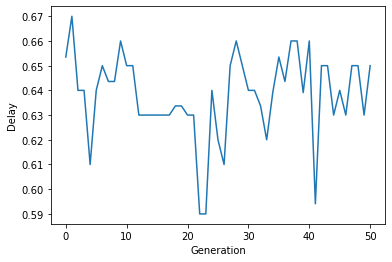

In [23]:
result = geneticAlgorithm(pop, popSize, eliteSize, mutationRate, generations)

In [24]:
print("training delay")
print(result.delay)
print("training deadline:")
result.debug()

training delay
0.7442
training deadline:
bid:  [0.         0.55230791 0.44769209]
t:  [1. 1. 1.]
0.7442



In [25]:
print(run_all_training_test(result))
print(run_all_test(result))
#Cost Sharing
def run_test(head):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_test)):
        test_number+=1
        test = copy.deepcopy(X_test[i])
        
        temp_sum_delay, temp_max_delay_list = run_loop(test,head)

        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
    if(target == "min_sum"):
        return sum_delay/test_number
    if(target == "min_max"):
        return max_delay/test_number

    return max_delay/test_number,sum_delay/test_number

ans_result = run_test(result) 
print("test:",ans_result)

0.7442
0.7541
test: 0.7541


In [26]:
print("pure CS")
run_cs_prue()

pure CS
max_delay 0.7822
sum_delay 1.7566


In [27]:
class Foo(object):

    def __init__(self, test_item, test_change_item, deadline):
        self.test_item = test_item
        self.test_change_item = test_change_item
        self.deadline = deadline

    def __lt__(self, other):
        return self.test_change_item < other.test_change_item
    
def cost_sharing_with_deadline(test,t_c,target):
    temp_max_delay_list=[0 for i in range(len(test))]
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for ii in range(len(test)):
            item= test[ii]
            if(item+1e-9>=target/k):
                count+=1;
            else:
                delay+=t_c[ii];
                temp_max_delay_list[ii]=t_c[ii]
            
        if(count>=k):
            temp_sum_delay+=delay;
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay_list=t_c
            temp_sum_delay=sum(t_c);
            result=False
            
    return temp_max_delay_list,temp_sum_delay,result
    
def cost_sharing_with_deadline_free(n,_i,numbers_of_people_will_pay,started_k):
    
    for k in range(started_k,0,-1):
        if(n-_i<=k):
            x=k-1
        else:
            x=k
        #print(n,_i,x,numbers_of_people_will_pay[x],k)
        if(numbers_of_people_will_pay[x]>=k):
            return True,k
    return False,0
    
#Cost Sharing
def run_cs_test(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    seconds_start=time.time()
    for i in range(len(X_test)):
#        if(i%1000==0):
#            seconds=time.time()
#            print("times: ",seconds-seconds_start)
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change_temp = []
        Foo_list = []
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        
        for j in range(len(test)):
            test_change_temp.append(test[j] * deadline_list[j])
            Foo_list.append(Foo(test[j],test_change_temp[j],deadline_list[j]))
            
        Foo_list.sort(reverse=False)
        

        for j in range(len(test)):
            test[j]=Foo_list[j].test_item
            test_change_temp[j]=Foo_list[j].test_change_item
            deadline_list[j]=Foo_list[j].deadline

        test_change = copy.deepcopy(test_change_temp);
        
        numbers_of_people_will_pay = [-10 for ii in range(len(test_change)+2)]#pay 1/k
        
#         seconds=time.time()
#         print("times: ",seconds-seconds_start)
        
        k = 1
        started=len(test_change)-1
        end_k=-10
        for j in range(len(test_change)):
            if(k<=len(test_change)):
                for people_id in range(started,-1,-1):
                    if(test_change[people_id]+1e-9>=1.0/k):
                        started=people_id
                        numbers_of_people_will_pay[k]=len(test_change)-people_id
                        end_k=len(test_change)-people_id
                    else:
                        k+=1
                        break;
                    
        for j in range(k,len(test_change)+1):
            numbers_of_people_will_pay[j]=end_k
            
        deadlist_new=copy.deepcopy(deadline_list)
        
        temp_max_delay_list,temp_sum_delay,judge_i =  cost_sharing_with_deadline(test_change,
                        deadlist_new,1.0)
        
        judge_i= True
        started_k = len(test)
        for _i in range(len(test_change)):
            if judge_i:
                judge_i,started_k =  cost_sharing_with_deadline_free(len(test_change),
                    _i,numbers_of_people_will_pay,started_k)
                
                
            started_k+=1
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[_i])
                temp_max_delay_list[_i] += (1.0-deadline_list[_i])
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
                
    #print("max_delay",max_delay/test_number);
                

    return max_delay/test_number,sum_delay/test_number

In [28]:
list_1=[]
list_2=[]
list_3=[]
for i in range(1,101):
    x=float(i)/100
    xx=[x for i in range(Agent_number_n)]
    #print(xx)
    res1,res2=run_cs_test(xx)
    list_1.append(res1)
    list_2.append(res2)
    list_3.append(x)
print("max_delay:",min(list_1),"deadline:",list_3[list_1.index(min(list_1))])
print("sum_dealy:",min(list_2),"deadline:",list_3[list_2.index(min(list_2))])

max_delay: 0.7822 deadline: 1.0
sum_dealy: 1.7566 deadline: 1.0


In [29]:
print("target:",target)
print("sum_delay")
print("diff_deadline:",min(list_2))

target: min_max
sum_delay
diff_deadline: 1.7566


In [30]:
print("max_delay")
print("diff_deadline:",min(list_1))
#print("{:.4%}".format(run_cs_test(result.deadline)[0]/min(list_1)))

max_delay
diff_deadline: 0.7822


In [31]:
def cost_sharing_with_deadline_old(test,t_c,target):
    temp_max_delay_list=[0 for i in range(len(test))]
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for ii in range(len(test)):
            item= test[ii]
            if(item+1e-9>=target/k):
                count+=1;
            else:
                delay+=t_c[ii];
                temp_max_delay_list[ii]=t_c[ii]
            
        if(count>=k):
            temp_sum_delay+=delay;
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay_list=t_c
            temp_sum_delay=sum(t_c);
            result=False
            
    return temp_max_delay_list,temp_sum_delay,result



#Cost Sharing
def run_cs_old(deadline_list):
    sum_delay=0
    max_delay=0
    test_number=0
    for i in range(len(X_test)):
        test_number+=1
        temp_max_delay=0
        temp_delay=0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change = []

        for j in range(len(test)):
            test_change.append(test[j] * deadline_list[j])
            
        
        temp_max_delay_list,temp_sum_delay,judge1 = cost_sharing_with_deadline_old(test_change,
                        copy.deepcopy(deadline_list),1.0)
        for j in range(len(test_change)):
            test_i = copy.deepcopy(test_change);
            test_i = np.delete(test_i, j)
            
            deadline_i = copy.deepcopy(deadline_list);
            deadline_i = np.delete(deadline_i, j)
            
            temp_max_delay_i_list,temp_sum_delay_i,judge_i = cost_sharing_with_deadline_old(test_i,
                        deadline_i,1.0)
            
            if(judge_i==False):
                temp_sum_delay += (1.0-deadline_list[j])
                temp_max_delay_list[j] += (1.0-deadline_list[j])
                
            
        
        max_delay+=max(temp_max_delay_list)
        
        sum_delay+=temp_sum_delay
        
    print("deadline: ",deadline_list)
    print("sum_delay: ",sum_delay/test_number)
    print("max_delay: ",max_delay/test_number)
    print()
    return max_delay/test_number,sum_delay/test_number


ans_max = run_cs_old([list_3[list_1.index(min(list_1))] for i in range(Agent_number_n)])[0]
print(ans_max)
print()
ans_sum = run_cs_old([list_3[list_2.index(min(list_2))] for i in range(Agent_number_n)])[1]
print(run_cs_old([list_3[list_2.index(min(list_2))] for i in range(Agent_number_n)]))

deadline:  [1.0, 1.0, 1.0]
sum_delay:  1.7566
max_delay:  0.7822

0.7822

deadline:  [1.0, 1.0, 1.0]
sum_delay:  1.7566
max_delay:  0.7822

deadline:  [1.0, 1.0, 1.0]
sum_delay:  1.7566
max_delay:  0.7822

(0.7822, 1.7566)


In [32]:
print("one deadline sum delay:",ans_sum)
print("one deadline max delay:",ans_max)
print("ga targaet delay:",target,ans_result)
if(target == "min_sum"):
    print("{:.4%}".format(ans_result/ans_sum))
else:
    print("{:.4%}".format(ans_result/ans_max))

one deadline sum delay: 1.7566
one deadline max delay: 0.7822
ga targaet delay: min_max 0.7541
96.4076%


In [33]:
target = "min_max"
ans_result2 = run_test(result) 

if(target == "min_sum"):
    print("{:.4%}".format(ans_result2/ans_sum))
else:
    print("{:.4%}".format(ans_result2/ans_max))

96.4076%
